## Aufgabe 5, Teil a

N =  60


hx =  0.13115


M =  37


Nr_timesteps =  1066


ans =

   39   62



fig_index =

    106    213    319    426    533    639    746    852    959   1066



Figure 1


test = a-Fig_1.jpg


Figure 2.0094


test = a-Fig_2.jpg


Figure 3.0094


test = a-Fig_3.jpg


Figure 4.0189


test = a-Fig_4.jpg


Figure 5.0283


test = a-Fig_5.jpg


Figure 6.0283


test = a-Fig_6.jpg


Figure 7.0377


test = a-Fig_7.jpg


Figure 8.0377


test = a-Fig_8.jpg


Figure 9.0472


test = a-Fig_9.jpg


Figure 10.0566


test = a-Fig_10.jpg

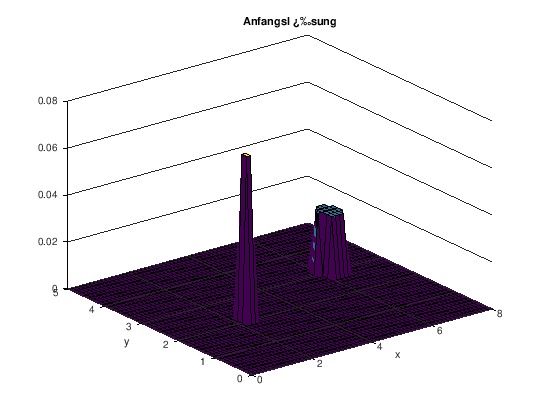

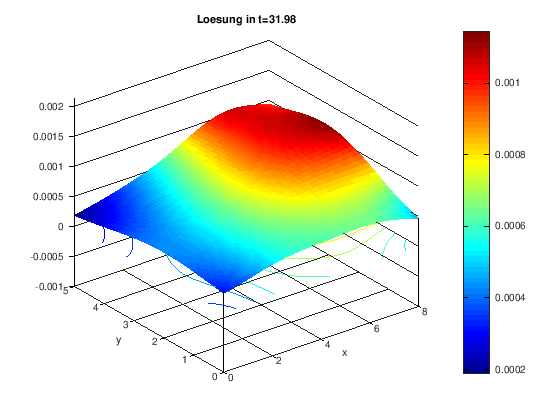

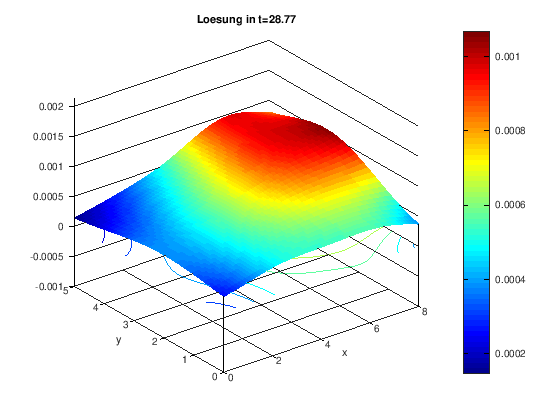

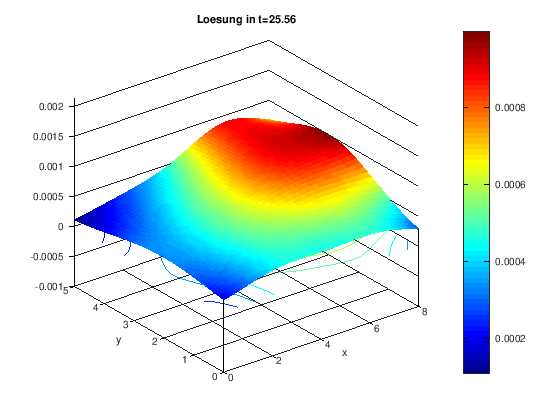

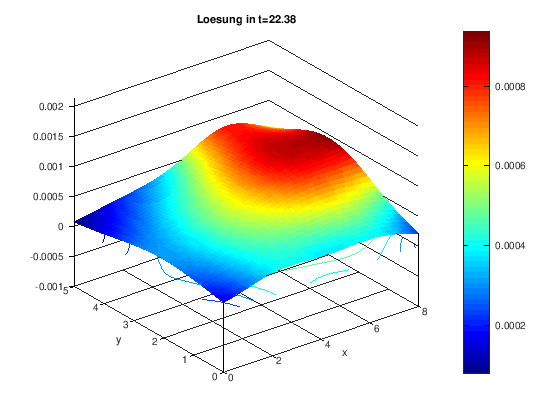

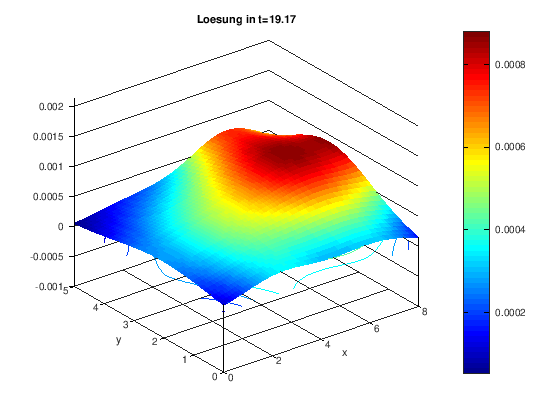

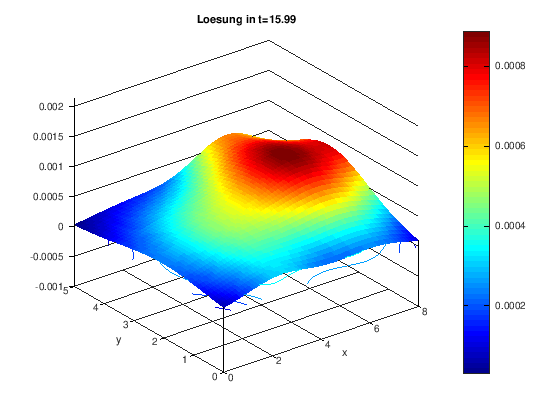

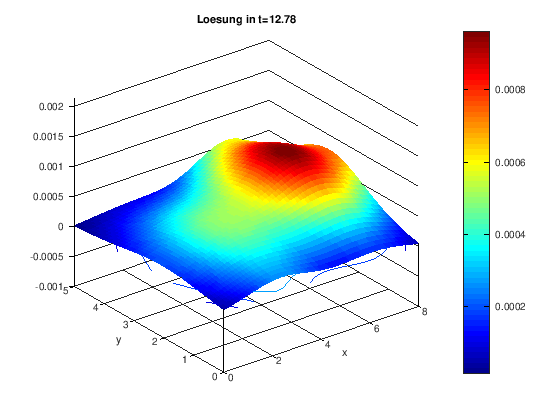

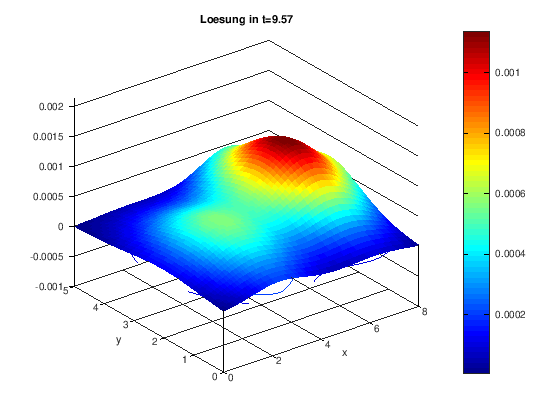

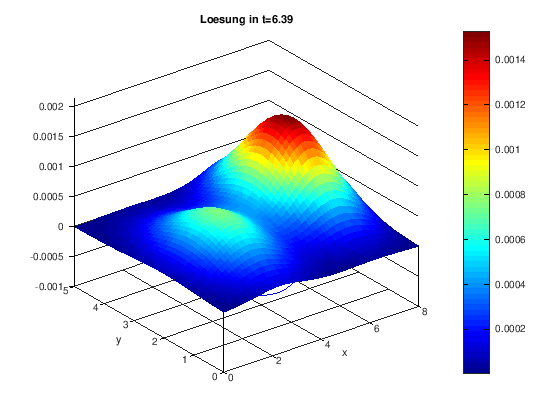

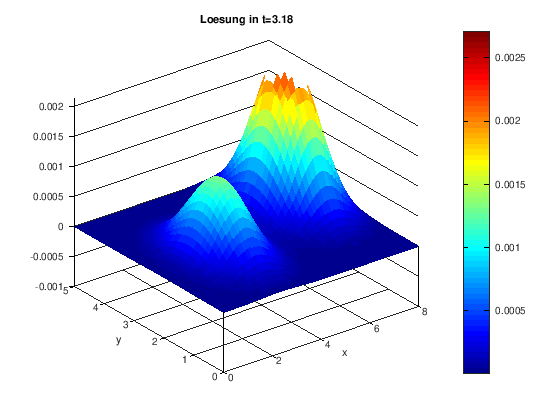

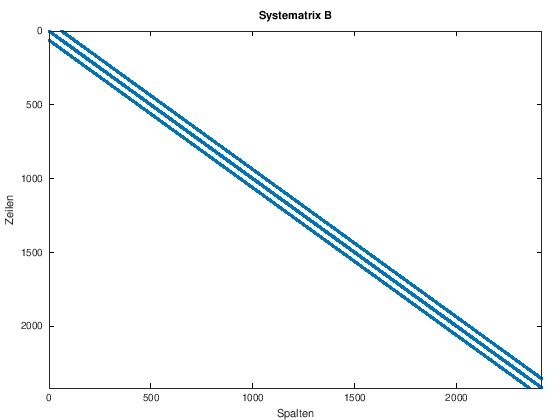

In [1]:
%Author Anna Hundertmark 2020
 
%Dieses Skript loest die instationaere Diffusionsgleichung mit Finiten Differenzen Verfahren
% an einem Rechteckigem Gebiet D=(0,Xend)x(0,Yend) mit einem konstanten Diffusionskoeffizienten
% auf einem aus Qudraten bestehendem Gitter.

%Funktionsparameter: N-Anzahl von Gitterpunkten in x Richtung  (0-te und N-te Index entsprechen den Rändern) 
%definiere Gebiet

close all
clear all
 
 %------Eingabe--------- 
  xend=8; %in km
  yend=5.0; %in km
  N=60 %N-Anzahl von Gitterpunkten in x Richtung  (0-te und N-te Index entsprechen den Rändern)
   a=0.1; %(konstanter Diffusionskoeffizient)
   T=32; %(Zeitintervall in Tagen)
   delta_t=0.03; %(Zeitschritt pro Tag)
   
   %Für Reaktionsdiffusionsgliechung:
   B=232;  %EW/km^2 -> Statista
   c=0.03238;    %(Infektionsrate, Vorsicht k=c/B in unserem Modell k.u.(B-u)-w.u)
   
   %function val=slowdown(x,t)
   % Ab Tag t (Argument der Funktion) wird die Infektionsrate  in mehreren Schritten sinken:
   %if x<t val=1 ; 
   % else  if x<t +10 val=t./(x.^1.05); 
   % else if x<t +22 val=t./(x.^1.2); 
   % else val=t./(x.^1.27)  ;
   %endif
   %endif
   %endif
  %Beispielhafte Lockerung der Maßnahmen ab Tag 80, die die Infektionsrate wieder auf 50 % der Basisinfektionsrate erhöht
  %(um den Effekt der Lockerung zu beobachten)
  %if x> 80  val=0.5; endif
  %endfunction
  
   w=1/14; %Wechselrate von Infiziert zu Genesen oder Toten
    %--------------
  
  
  hx=xend/(N+1)
  hy=hx;
  M=floor((yend/hy))-1
  Nr_timesteps=floor (T/delta_t)
 
 %---- Anfangsfunktion -------------
  
 function wert=initialfunction(x,y)
  wert=0;
  r1=0.35;
  r2=0.15;
  if sqrt((x.-6.25).^2+(y.-3).^2)<=r1 wert=1/(pi*r1^2);
    elseif  sqrt((x.-2.25).^2+(y.-2).^2)<=r2 wert=0.5/(pi*r2^2);
  endif
 endfunction
 
  %--------------------
    %Koordinatenmatrix
  %--------------------
  
  %Neumann RB, 
  %erweitertes Gitter um die  Randpunkte 
  
  [x,y]=meshgrid(0:hx:xend,0:hy:yend);
  N=N+2;
  M=M+2;
 
  
% Systemmatrix
%-------------------------------------------
  Vec1=ones(N*M,1); % erzeugt vektor der  Laenge N*M
  BB=diag(-4.*Vec1,0)+diag(ones(N*M-1,1),1)+ diag(ones(N*M-1,1),-1)+diag(ones(N*(M-1),1),N)+diag(ones(N*(M-1),1),-N);
  % Systemmatrix N^2xN^2 mit -4 auf der Diagonale und 1 auf den Nebendiagonalen 
  %und 1 auf den N und -N-ter Nebendiagonale 
  
  
%Korrektur der Matrix (Blockdiagonalitaet)
  for  i=1:(M-1) 
      BB(i*N+1,i*N)=0;BB(i*N,i*N+1)=0;
  endfor
  
 
%------------------------------------------- 
  % Matrix mit Diffkoeff/h^2 multiplizieren
%-------------------------------------------
  BB=BB*a/hx^2;
  %--------------------------
  %RANDBEDINGUNGEN
  %-------------------------------------------
  % Neumann RB f�r y:   a* partial_y u=0   - einzelne Bl�cke der Matrix ersetzen
    block=diag((a/hx)*ones(N,1));
    %unterer Rand
    BB(1:N,1:N)=-block;
    BB(1:N,N+1:2*N)=block;
   %Auskommenteren heisst 0 Dirichlet
   %oberer Rand
   BB(N*(M-1)+1:N*M,N*(M-1)+1:N*M)=-block;
   BB(N*(M-1)+1:N*M,N*(M-2)+1:N*(M-1))=block;
   %--------------------------
  % Neumann RB f�r x:   a* partial_x u=0 - einzelne Zeilen der Matrix ersetzen
 
  for i=1:(M-2)% bei full neumann 0:(M-1)
    vector_up=zeros(1,N*M);
    vector_up(N*i+1)=a/hx;
    vector_up(N*i+2)=-a/hx;
    vector_down=zeros(1,N*M);
    vector_down(N*i+N)=a/hx;
    vector_down(N*i+N-1)=-a/hx;
    BB(i*N+1,:)  =-vector_up ;
    BB(i*N+N,:)  =-vector_down ;
   endfor
 %-------------------------------------------
  
  
  
  
  %Matrixdarstellung - optional
  figure (11);
  spy (BB);
  xlabel("Spalten")
  ylabel("Zeilen")
  zlabel("Matrix B")
  title ("Systematrix B");
  
 %Anfangsl�sung als Matrix
 %-------------------------------------------
  for  i=1:N
  for j=1:M
   initial(j,i)=0.01*initialfunction(x(j,i),y(j,i));
   %0.005 und 0.01 (in Tausend) d.h. 5 und 10 pro gegebene Fl�che pi*R^2
  endfor  
  endfor
  %-----------
    
  
  size (initial)
  sol_old=1*reshape(initial',N*M,1);
  %reshape funktioniert Spaltenm�ssig: Sp1,Sp2, wir wollen Zeilenm�ssig
  %Matrix f' ist N(Zeilen)x M(Spalten)
  
  % LOESUNGSSCHRITT: explizites Eulerverfahren
  %-------------------------------------------------
  %Slowdown für c
  function c=C(i,t);
    T1=floor(t/4);
    T2=2*T1;
    T3=3*T1;
    if(i<=T1)
      c=0.03238;
    elseif(i<=T2)
      c=0.01238;
    elseif(i<=T3)
      c=0.04238;
    else
      c=0.03238;
    endif
  endfunction
  %-------------------------------------------------
  % Hier kann Reaktionsterm  f�r kummuierte  oder aktielle Infizierte
  %implementiert werden
  F=@(u)(c/B).*u.*(B.-u);
  %Reaktionsterm aktuell Infizierte
  %F=@(u)(c./B).*u.*(B.-u).-w.*u;
  
  for i=1:Nr_timesteps
  c=C(i,Nr_timesteps);
  sol= sol_old+ BB*sol_old*delta_t + 1*F(sol_old)*delta_t;
 
  sol_old=sol;
  matrix_solution(:,i)=sol;

endfor

% Auswahl an Bildern dr�cken, jedeS zehnte Bild
fig_index=floor([0.1:0.1:1]*Nr_timesteps)
j=0;
 for i=fig_index
  sol_matrix=reshape(matrix_solution(:,i),N,M);% Matrix mit N(Zeilen)x M(Spalten)
  sol_matrix=sol_matrix';
  disp(['Figure ',num2str(i/fig_index(1))]);
  j=j+1;
  figure(j);
  surfc(x,y,sol_matrix, "EdgeColor", "none")
 % colormap: autumn,  hsv jet ocean
  colormap ("jet")
  colorbar
  axis([0 xend 0 yend -0.001 0.03*max(max (initial))])
  title (["Loesung in t=", num2str(delta_t*i)]);
  ylabel("y")
  xlabel("x")
  %Optional: Speicherung der Bilder
  test=["a-Fig_", num2str(j),".jpg"]
  saveas(j, test)
endfor
%-------------------------------------------------
  
  
  %weiteres Bild mit Anfangsfunktion
  figure(Nr_timesteps+1);
  surfc(x,y,initial);
  title ("Anfangsl�sung");
  ylabel("y")
  xlabel("x")
  